# Import Library & Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

DATASET_PATH = '../data/cleaned_data_saudi_used_cars.csv'
OUTPUT_PATH = '../data/cleaned_outliers_data_saudi_used_cars.csv'

In [3]:
df = pd.read_csv(DATASET_PATH)
display(df.head())

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000


# Helper Functions for Visualization

For Numerical:

In [5]:
def plot_hist(series, bins, title, xlabel):
    plt.figure(figsize=(10, 5))
    sns.histplot(series, bins=bins, kde=True, color='#1976d2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def plot_box(series, title, xlabel):
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=series, color='#1976d2')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

For Categorical:

In [8]:
def top_n_barplot(series, n=20, title=None, xlabel=None):
    counts = series.value_counts()
    plt.figure(figsize=(12, 6))
    counts.head(n).plot(kind='bar')
    plt.title(title or f'Top {n} Most Common')
    plt.ylabel('Count')
    plt.xlabel(xlabel or series.name)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    print("\nTop 20 most common Types:")
    print(counts.head(n))

def find_near_duplicates(series):
    raw = pd.Series(series.unique())
    suspect = raw[raw.str.strip().str.lower().duplicated(keep=False)]
    print(f"Possible near-duplicate or inconsistent names:\n{suspect}")

def pareto_coverage(series, target_pct=0.8):
    counts = series.value_counts()
    cumsum = counts.cumsum() / counts.sum()
    N_target = (cumsum >= target_pct).argmax() + 1
    label = (cumsum >= target_pct).idxmax()
    
    # Calculate percentages
    percentage_of_unique_types = (N_target / len(counts)) * 100
    top_n_percentage = cumsum.values[N_target-1] * 100
    
    print(f"\nTop {N_target} {series.name}s account for {int(target_pct*100)}% of the data. {int(target_pct*100)}th percentile: {label}")
    print(f"These top {N_target} models represent {percentage_of_unique_types:.2f}% of all unique values in this feature, and they represent {top_n_percentage:.2f}% of all cars in the dataset.")
    
    plt.figure(figsize=(10, 4))
    plt.plot(cumsum.values, label='Cumulative Coverage')
    plt.axhline(target_pct, color='r', linestyle='--', label=f'{int(target_pct*100)}% Coverage')
    plt.axvline(N_target, color='g', linestyle='--', label=f'N = {N_target}')
    plt.scatter(N_target, cumsum.values[N_target-1], color='g', zorder=5)
    plt.text(N_target, cumsum.values[N_target-1]+0.05, f'N={N_target}', color='g', ha='center')
    plt.title(f'Cumulative Coverage of {series.name} Frequency')
    plt.xlabel(f'Top N {series.name}s')
    plt.ylabel('Cumulative % of Data')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return N_target, label

def rare_categories(series, threshold=10):
    counts = series.value_counts()
    rare = counts[counts < threshold]
    pct = (len(rare) / len(counts)) * 100
    print(f"Rare {series.name}s (<{threshold} rows): {len(rare)} of {len(counts)} total ({pct:.2f}%)")
    if not rare.empty:
        print("Example rare values:", rare.head())
        
def feature_value_counts(series):
    print(f"Unique {series.name} values:", series.unique())
    value_counts = series.value_counts()
    print(value_counts)

    # Percentage breakdown
    print("\nPercentage breakdown:")
    value_percentages = (value_counts / value_counts.sum() * 100).round(2)
    print(value_percentages)

def plot_categorical_distribution(series):
    counts = series.value_counts()
    n_unique = counts.shape[0]
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    colors = default_colors[:min(n_unique, 4)]
    
    plt.figure(figsize=(7, 4))
    counts.plot(kind='bar', color=colors)
    plt.title(f'Distribution of {series.name}')
    plt.ylabel('Count')
    plt.xlabel(series.name)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
# ---- Helper for boxplot by category ----
def boxplot_by_category(df, cat_col, num_col='Price', top_n=None, sort_by_median=True, figsize=(16,6)):
    """
    Plots boxplot of num_col by cat_col, optionally only for the top_n most frequent categories,
    and optionally sorted by median of num_col.
    """
    counts = df[cat_col].value_counts()
    if top_n is not None:
        keep = counts.head(top_n).index
        data = df[df[cat_col].isin(keep)]
    else:
        data = df
    if sort_by_median:
        order = data.groupby(cat_col)[num_col].median().sort_values().index
    else:
        order = None
    plt.figure(figsize=figsize)
    sns.boxplot(x=cat_col, y=num_col, data=data, order=order, showfliers=True)
    plt.title(f'{num_col} by Top {top_n} {cat_col} (Sorted by Median)') if top_n else plt.title(f'{num_col} by {cat_col} (Sorted by Median)')
    plt.xlabel(cat_col)
    plt.ylabel(num_col)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Outliers Detection & Handling

## Year

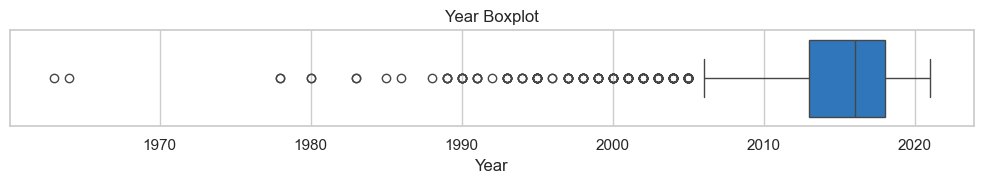

In [7]:
plot_box(df['Year'], title='Year Boxplot', xlabel='Year')